Importing Useful Stuff

In [1]:
import csv
import os
from functools import partial
import json

import geopandas as gpd
import matplotlib.pyplot as plt

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges, county_splits
from gerrychain.tree import recursive_tree_part
from gerrychain.constraints import SelfConfiguringUpperBound, SelfConfiguringLowerBound
from gerrychain.partition import GeographicPartition

Creating a path so I don't have to keep typing it, creating my dataframe and my graph (doing a graph this way is super slow so it's in its own cell so I don't have to rerun the cell very often)

In [2]:
path = "./CompleteCOwithDemographics.shp"
ourjson = './CompleteCOwithDemographics.json'
df = gpd.read_file(path)

In [3]:
#graph = Graph.from_file(path)
graph = Graph.from_json(ourjson)

In [4]:
#graph.to_json('./CompleteCOwithDemographics.json')

Creating a file to save all the data from so stuff doesn't get cluttered.

In [4]:
newdir = "./PACongressReplicaSimpleOutput3/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")

Giving it information about the shapefile columns and elections and what not

In [5]:
unique_label = "VTDSD"
census_pop = "Sum_POP2_1"
#pop_est = "Sum_block_" this is awful for whatever reason and needs updating
congress = "CD116FP"
senate = "SLDUST"
house = "SLDLST"
county_field_name = "COUNTYFP"

num_elections = 5
election_names = [
    "AG18",
    "SEC18",
    "TRE18",
    "GOV18",
    "REG18",
]
election_columns = [
    ["AG_DEM18", "AG_REP18"],
    ["SEC_DEM18", "SEC_REP18"],
    ["TRE_DEM18", "TRE_REP18"],
    ["GOV_DEM18", "GOV_REP18"],
    ["REG_DEM18", "REG_REP18"],
]

num_districts = 7

In [6]:
############ Why this isn't an updater I'm not entirely sure...  UPDATE: It is now as far as I'm concerned
def num_splits(partition, df=df, level = county_field_name):
    df["current"] = df[unique_label].map(dict(partition.assignment))
    splits = sum(df.groupby(level)["current"].nunique() > 1)
    return splits
splits_constraint = SelfConfiguringUpperBound(num_splits)

In [7]:
def polsby_popper_average(partition):
    total = 0
    size = 0
    dictionary = polsby_popper(partition)
    for part in partition.parts:
        item = dictionary[part]
        inverse = 1 / item
        total += inverse
        size += 1
    return total / size

In [8]:
polsby_popper_constraint = SelfConfiguringUpperBound(polsby_popper_average)

In [9]:
myupdaters = {
    "population": updaters.Tally(census_pop, alias="population"),
    "cut_edges": cut_edges,
    "county_splits": num_splits,
    "polsby_popper": polsby_popper,
    "polsby_popper_average": polsby_popper_average
}

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}

myupdaters.update(election_updaters)

In [10]:
enacted_partition = GeographicPartition(graph = graph, assignment = congress, updaters = myupdaters)
ideal_population = sum(enacted_partition['population'].values()) / len(enacted_partition)
print(ideal_population)

### This is how you create a random starting seed
#cddict = recursive_tree_part(graph, range(num_districts), ideal_population, census_pop, .001, 1)

#df['random'] = df.index.map(cddict)

#df.plot(column = 'random', cmap = 'jet')
#plt.savefig(newdir + 'random.png')
#plt.close()

#with open(newdir + 'random.json', 'w') as jf1:
#    json.dump(cddict, jf1)
    
#random_partition = Partition(graph, cddict, updaters)

chosen_partition = enacted_partition

718456.5714285715


In [11]:
for district, pop in chosen_partition["population"].items():
    print("District {}: {}".format(district, pop))

District 04: 718435.0
District 05: 718488.0
District 03: 718719.0
District 01: 717094.0
District 06: 718460.0
District 02: 718377.0
District 07: 719623.0


AxesSubplot(0.125,0.170331;0.775x0.664339)


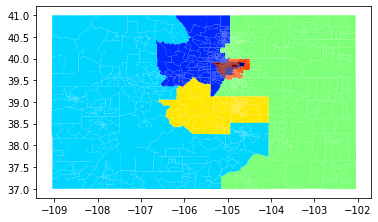

In [20]:
#print(df.plot(column = 'random', cmap = 'jet'))
print(df.plot(column = congress, cmap = 'jet'))

In [11]:
proposal = partial(
    recom, pop_col=census_pop, pop_target=ideal_population, epsilon=0.02, node_repeats=2
)

In [12]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(enacted_partition, 0.01),
        polsby_popper_constraint, 
        splits_constraint, 
        constraints.contiguous # single_flip_contiguous#no_more_discontiguous
    ],
    accept=accept.always_accept,
    initial_state=chosen_partition,
    total_steps=1000,
)

In [13]:
with open(newdir + "Start_Values.txt", "w") as f:
    f.write("Values for Starting Plan: Random Plan\n \n ")
    f.write("Initial Cut: " + str(len(chosen_partition["cut_edges"])))
    f.write("\n")
    f.write("\n")
    f.write("Initial County Splits: " + str(num_splits(chosen_partition)))
    f.write("\n")
    f.write("\n")
    f.write("Initial Polsby-Popper: " + str(polsby_popper(chosen_partition)))
    f.write("\n")
    f.write("\n")
    f.write("Initial Polsby-Popper Inverse Average: " + str(polsby_popper_average(chosen_partition)))
    f.write("\n")
    f.write("\n")

    for elect in range(num_elections):
        f.write(
            election_names[elect]
            + "District Percentages"
            + str(
                sorted(chosen_partition[election_names[elect]].percents("Democratic"))
            )
        )
        f.write("\n")
        f.write("\n")

        f.write(
            election_names[elect]
            + "Mean-Median :"
            + str(mean_median(chosen_partition[election_names[elect]]))
        )

        f.write("\n")
        f.write("\n")

        f.write(
            election_names[elect]
            + "Efficiency Gap :"
            + str(efficiency_gap(chosen_partition[election_names[elect]]))
        )

        f.write("\n")
        f.write("\n")

        f.write(
            election_names[elect]
            + "How Many Seats :"
            + str(chosen_partition[election_names[elect]].wins("Democratic"))
        )

        f.write("\n")
        f.write("\n")

In [14]:
pop_vec = [] #population
cut_vec = [] #cut edges
votes = [[], [], [], [], []] #one list for each election
mms = [] #mean median list of lists eventually
egs = [] #efficiency gap list of lists eventually
hmss = [] #democratic seat share
pp = [] #polsby popper
pp_avg = [] #inverse average polsby popper

splits = []

t = 0
for part in chain:
    splits.append(part['county_splits'])
    pp.append(sorted(list(part['polsby_popper'].values())))
    pp_avg.append(part['polsby_popper_average'])

    pop_vec.append(sorted(list(part["population"].values())))
    cut_vec.append(len(part["cut_edges"]))
    mms.append([])
    egs.append([])
    hmss.append([])

    for elect in range(num_elections):
        votes[elect].append(sorted(part[election_names[elect]].percents("Democratic")))
        mms[-1].append(mean_median(part[election_names[elect]]))
        egs[-1].append(efficiency_gap(part[election_names[elect]]))
        hmss[-1].append(part[election_names[elect]].wins("Democratic"))

    t += 1
    if t % 100 == 0:
        print(t)
        with open(newdir + "mms" + str(t) + ".csv", "w") as tf1:
            writer = csv.writer(tf1, lineterminator="\n")
            writer.writerows(mms)
            
        with open(newdir + "pp" + str(t) + ".csv", "w") as tf1:
            writer = csv.writer(tf1, lineterminator="\n")
            writer.writerows([pp])
        
        with open(newdir + "pp_avg" + str(t) + ".csv", "w") as tf1:
            writer = csv.writer(tf1, lineterminator="\n")
            writer.writerows([pp_avg])

        with open(newdir + "egs" + str(t) + ".csv", "w") as tf1:
            writer = csv.writer(tf1, lineterminator="\n")
            writer.writerows(egs)

        with open(newdir + "hmss" + str(t) + ".csv", "w") as tf1:
            writer = csv.writer(tf1, lineterminator="\n")
            writer.writerows(hmss)

        with open(newdir + "pop" + str(t) + ".csv", "w") as tf1:
            writer = csv.writer(tf1, lineterminator="\n")
            writer.writerows(pop_vec)

        with open(newdir + "cuts" + str(t) + ".csv", "w") as tf1:
            writer = csv.writer(tf1, lineterminator="\n")
            writer.writerows([cut_vec])

        with open(newdir + "splits" + str(t) + ".csv", "w") as tf1:
            writer = csv.writer(tf1, lineterminator="\n")
            writer.writerows([splits])

        with open(newdir + "assignment" + str(t) + ".json", "w") as jf1:
            json.dump(dict(part.assignment), jf1)

        for elect in range(num_elections):
            with open(
                newdir + election_names[elect] + "_" + str(t) + ".csv", "w"
            ) as tf1:
                writer = csv.writer(tf1, lineterminator="\n")
                writer.writerows(votes[elect])

        df["plot" + str(t)] = df.index.map(dict(part.assignment))
        df.plot(column="plot" + str(t), cmap="jet")
        plt.savefig(newdir + "plot" + str(t) + ".png")
        plt.close()

        votes = [[], [], [], [], []]
        mms = []
        egs = []
        hmss = []
        pop_vec = []
        cut_vec = []
        splits = []
        pp = []
        pp_avg = []

100
200
300
400
500
600
700
800
900
1000
